# IMPORT LIBRARY DAN CONNECT GOOGLE DRIVE

In [1]:
#import library

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import keras

import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

import xgboost as xgb

from keras.regularizers import l1
from keras.regularizers import l2


import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
#connect google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Add File

In [3]:
data_file_train = 'gdrive/My Drive/dataset/minggu 2/train.csv'
data_file_test = 'gdrive/My Drive/dataset/minggu 2/test.csv'

train = pd.read_csv(data_file_train)
test = pd.read_csv(data_file_test)

# MAIN PROGRAM


In [4]:
#menampilkan data teratas pada train

print("Data Train\n")
train.head()


Data Train



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print("Data Test\n")
test.head()

Data Test



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
#Menggabungkan data menjadi 1
#loc: untuk seleksi dengan menggunakan label/bilangan bulat
#Pada index yang berisi “:” itu menandakan memilih semua semua urutan pada index.
#:,'MSSubClass':'SaleType' artinya memilih semua index dan dari kolom msubclass sampe salecondition

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

all_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,GasA,Ex,Y,SBrkr,796,566,0,1362,1.0,0.0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,GasA,Ex,Y,SBrkr,1694,0,0,1694,1.0,0.0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,GasA,Ex,Y,SBrkr,1107,983,0,2090,1.0,0.0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,GasA,Gd,Y,FuseF,1022,752,0,1774,0.0,0.0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,

Data preprocessing:

1. Pertama akan mengubah fitur numerik miring dengan mengambil log (fitur + 1) - ini akan membuat fitur lebih normal
2. Buat variabel Dummy untuk fitur kategoris
3. Ganti nilai numerik yang hilang (NaN) dengan rata-rata kolom masing-masing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f501b9a2d90>,
      dtype=object)

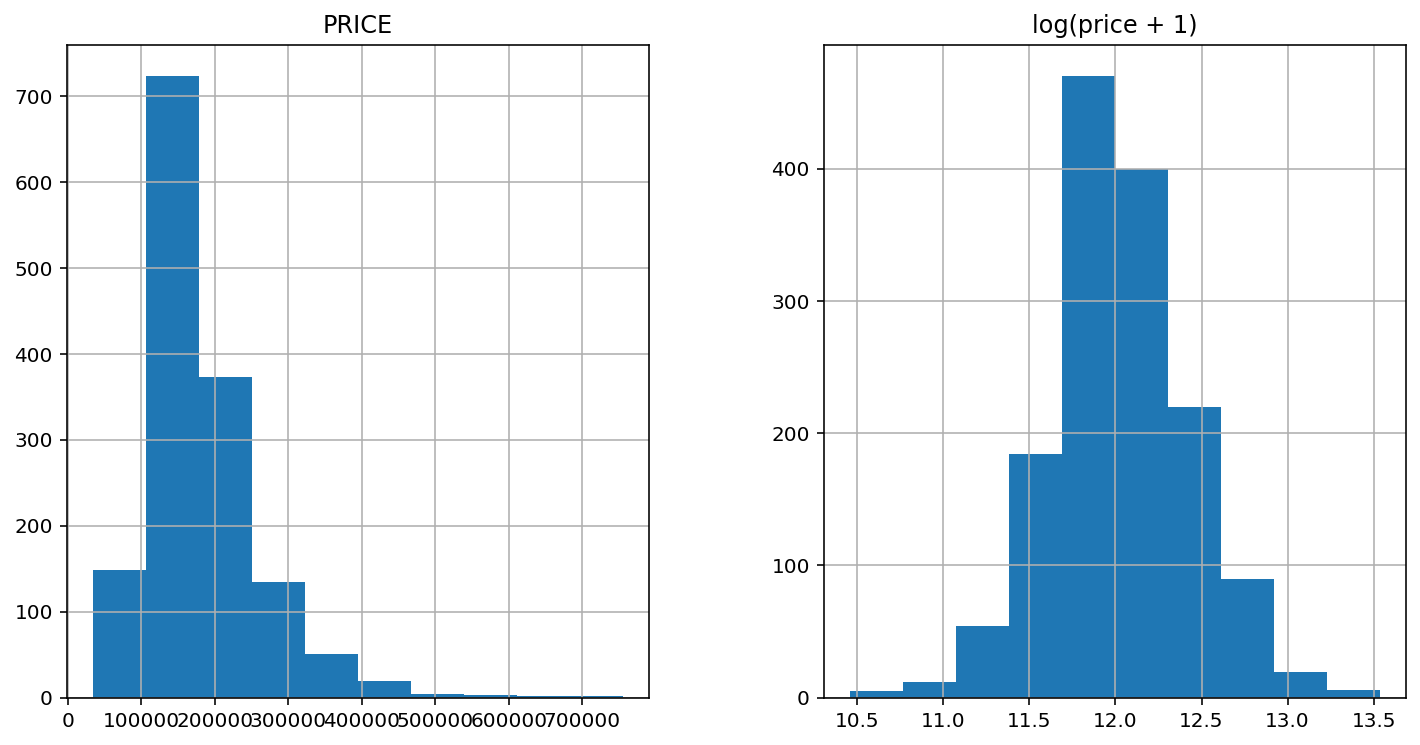

In [7]:
#membuat lebar gambar 12 inci, dan tingginya 6 inci
#log1p() adalah fungsi matematika yang membantu pengguna untuk menghitung nilai logaritmik alami x + 1 di mana x milik semua elemen array input. log1p adalah kebalikan dari exp(x) – 1.

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"PRICE":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [8]:
#transform()sangat berguna saat Anda ingin memanipulasi baris atau kolom.
#Skewness adalah ukuran ketidaksimetrisan dalam distribusi nilai. mengambil fitur puncaknya diambil


#log mengubah target
train["SalePrice"] = np.log1p(train["SalePrice"])

#log mengubah fitur numerik miring
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data[skewed_feats].head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0


In [9]:
#get_dummies digunakan untuk mengubah variabel kategorikal menjadi variabel numerikal dengan melakukan proses One-Hot-Encode terhadap variabel kategorikal.
#variabel kuantitatif yang menggunakan nilai numerik, seperti usia, pendapatan, dan jumlah anak dalam sebuah keluarga.
#contoh variabel kategorik adalah golongan darah, preferensi genre musik, dan warna kesukaan

all_data = pd.get_dummies(all_data)

all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,8,0,2003.0,2.0,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,6,1,1976.0,2.0,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,6,1,2001.0,2.0,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,1.0,0.000000,1,0,3,0.693147,7,1,1998.0,3.0,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,7.695758,1.0,0.000000,2,1,4,0.693147,9,1,2000.0,3.0,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [10]:
#fillna menangani missing value yaitu dengan menghapusnya atau menggantinya dengan nilai yang lain

#mengisi NA's with rata2 dari kolom:
all_data = all_data.fillna(all_data.mean())

all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,1.0,0.000000,2,1,3,0.693147,8,0,2003.0,2.0,548.0,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,2,2008,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,0.0,7.141245,0.0,0.693147,2,0,3,0.693147,6,1,1976.0,2.0,460.0,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,5,2007,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,0.0,7.488294,1.0,0.000000,2,1,3,0.693147,6,1,2001.0,2.0,608.0,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,9,2008,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,0.0,7.448916,1.0,0.000000,1,0,3,0.693147,7,1,1998.0,3.0,642.0,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,2,2006,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,0.0,7.695758,1.0,0.000000,2,1,4,0.693147,9,1,2000.0,3.0,836.0,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,12,2008,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [11]:
#membuat matriks untuk sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

y.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

Models 

menggunakan model regresi linier reguler dari modul belajar scikit. disini akan mencoba regularisasi l_1(Lasso) dan l_2(Ridge). Selain itu juga akan mendefinisikan fungsi yang mengembalikan kesalahan rmse validasi silang sehingga dapat mengevaluasi model dan memilih par penyetelan terbaik

In [12]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

**Model Linear**

***MODEL RIDGE***

Parameter penyetelan utama untuk model Ridge adalah alfa - parameter regularisasi yang mengukur seberapa fleksibel model yang digunakan ini. Semakin tinggi regularisasi, semakin kecil kemungkinan model kita menjadi overfit. Namun itu juga akan menghilangkan fleksibilitas dan mungkin tidak menangkap semua sinyal dalam data.

In [13]:
model_ridge = Ridge()

In [14]:
#Error of Cross Validation (RMSECV)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
print(cv_ridge)

[0.13893637694024372, 0.13777538277187826, 0.1350143361808602, 0.13136184989399574, 0.12864892446111875, 0.12782179689257306, 0.1273373466867076, 0.12752940439753807, 0.12895888148450085, 0.13099437857191387, 0.13316366423370277]


Text(0, 0.5, 'rmse')

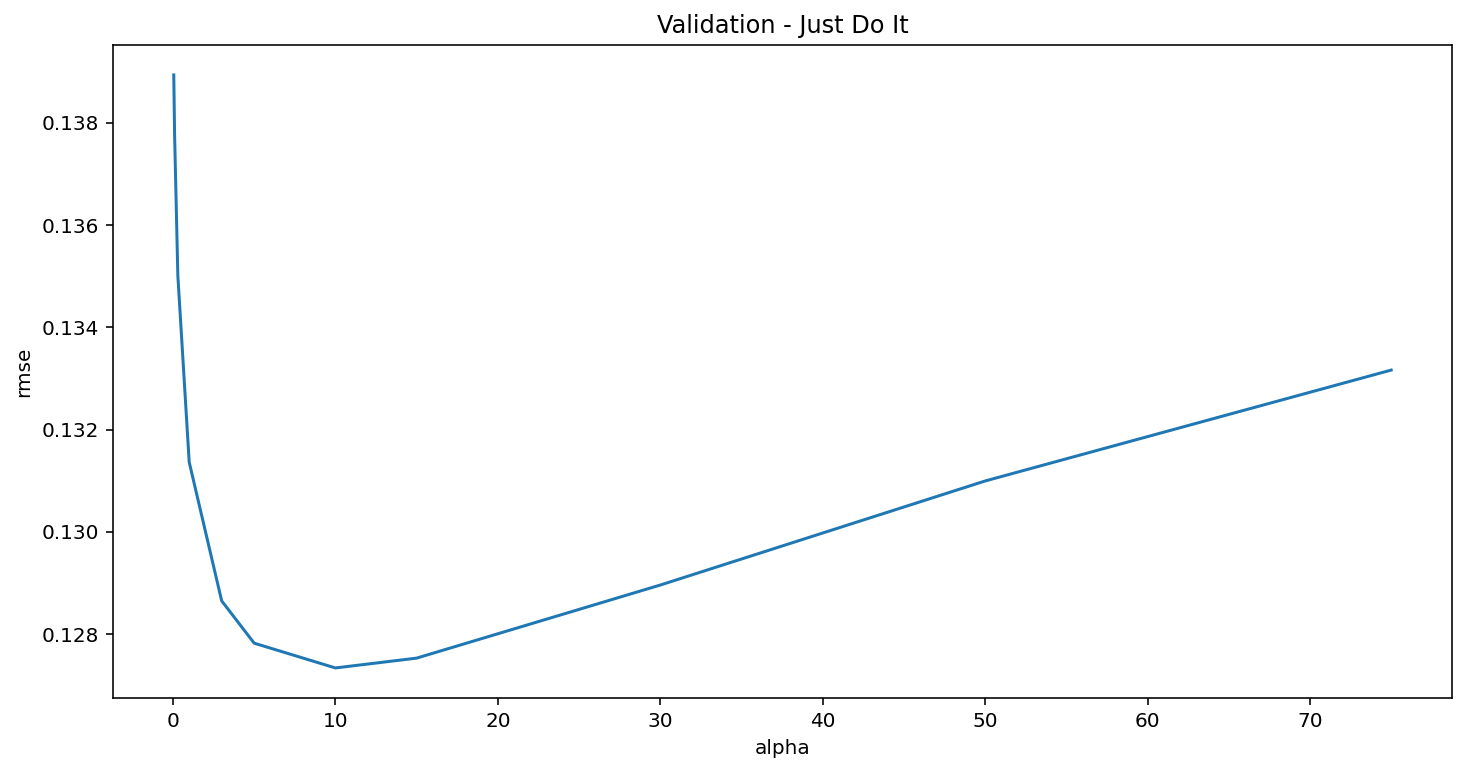

In [15]:
#Data Time Series merupakan jenis data yang dikumpulkan menurut urutan waktu dalam suatu rentang waktu tertentu. 


cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Perhatikan kurva berbentuk U-ish di atas. Ketika alfa terlalu besar, regularisasi terlalu kuat dan model tidak dapat menangkap semua kompleksitas dalam data. Namun jika kita membiarkan model terlalu fleksibel (alpha kecil), model mulai overfit. Nilai alpha = 10 kira-kira tepat berdasarkan plot di atas.

Overfitting terjadi karena model yang dibuat terlalu fokus pada training dataset tertentu, hingga tidak bisa melakukan prediksi dengan tepat jika diberikan dataset lain yang serupa.

In [16]:
ridge_min = cv_ridge.min()
ridge_max = cv_ridge.max()

print("Nilai Minimal Untuk Metode Ridge : ", ridge_min)
print("Nilai Maximal Untuk Metode Ridge : ", ridge_max)

Nilai Minimal Untuk Metode Ridge :  0.1273373466867076
Nilai Maximal Untuk Metode Ridge :  0.13893637694024372


***Model Laso***

Jadi untuk regresi Ridge mendapatkan rmsle sekitar 0,127

Mari coba model Lasso. disini akan melakukan pendekatan yang sedikit berbeda dan menggunakan CV Lasso bawaan untuk mencari tahu alfa terbaik. Untuk beberapa alasan alfa di Lasso CV benar-benar kebalikan atau alfa di Ridge.

In [17]:
#fit memiliki fungsi untuk menghitung rata-rata dan deviasi standar dari setiap kolom atribut untuk kemudian dipakai pada fungsi transform.
alphas = [1, 0.1, 0.001, 0.0005]

#model_lasso = [rmse_cv(LassoCV(alphas = alpha)).fit(X_train, y) for alpha in alphas]

model_lasso = LassoCV(alphas = alphas).fit(X_train, y)

mean_lasso = rmse_cv(model_lasso).mean()

print(mean_lasso)

0.12256735885048142


Laso berkinerja lebih baik jadi kami hanya akan menggunakan yang ini untuk memprediksi di set pengujian. Hal menarik lainnya tentang Lasso adalah ia melakukan pemilihan fitur untuk Anda - menyetel koefisien fitur yang dianggap tidak penting menjadi nol.

In [18]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print(coef)

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
                           ...   
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.007925
SaleCondition_Normal     0.019666
SaleCondition_Partial    0.000000
Length: 288, dtype: float64


In [19]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


Namun satu hal yang perlu diperhatikan di sini adalah bahwa fitur yang dipilih belum tentu yang "benar" - terutama karena ada banyak fitur collinear dalam kumpulan data ini. Satu ide untuk dicoba di sini adalah menjalankan Lasso beberapa kali pada sampel yang di-boost dan melihat seberapa stabil pemilihan fiturnya.

In [20]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

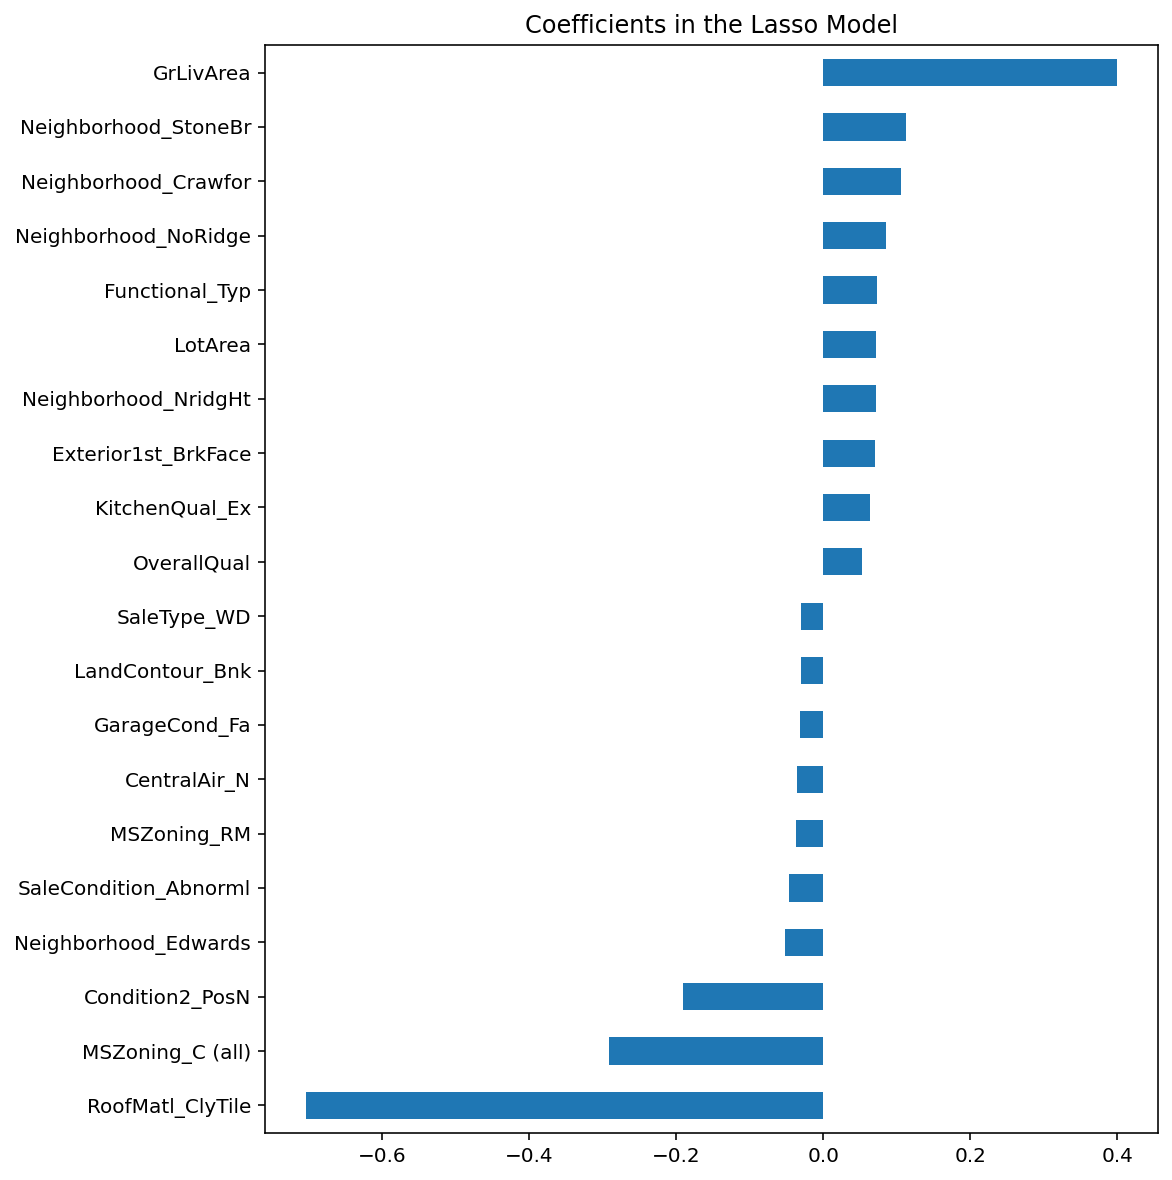

In [21]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Fitur positif yang paling penting adalah GrLivArea - area di atas tanah dengan luas kaki persegi. Ini pasti masuk akal. Kemudian beberapa fitur lokasi dan kualitas lainnya memberikan kontribusi positif. Beberapa fitur negatif kurang masuk akal dan layak untuk diteliti lebih lanjut - sepertinya fitur tersebut mungkin berasal dari variabel kategori yang tidak seimbang.


Perhatikan juga bahwa tidak seperti pentingnya fitur yang didapatkan dari random forest, ini adalah koefisien aktual dalam model - sehingga dapat mengatakan dengan tepat mengapa harga yang diprediksi seperti itu. Satu-satunya masalah di sini adalah bahwa mengubah log_ baik target dan fitur numerik sehingga besaran sebenarnya agak sulit untuk ditafsirkan.

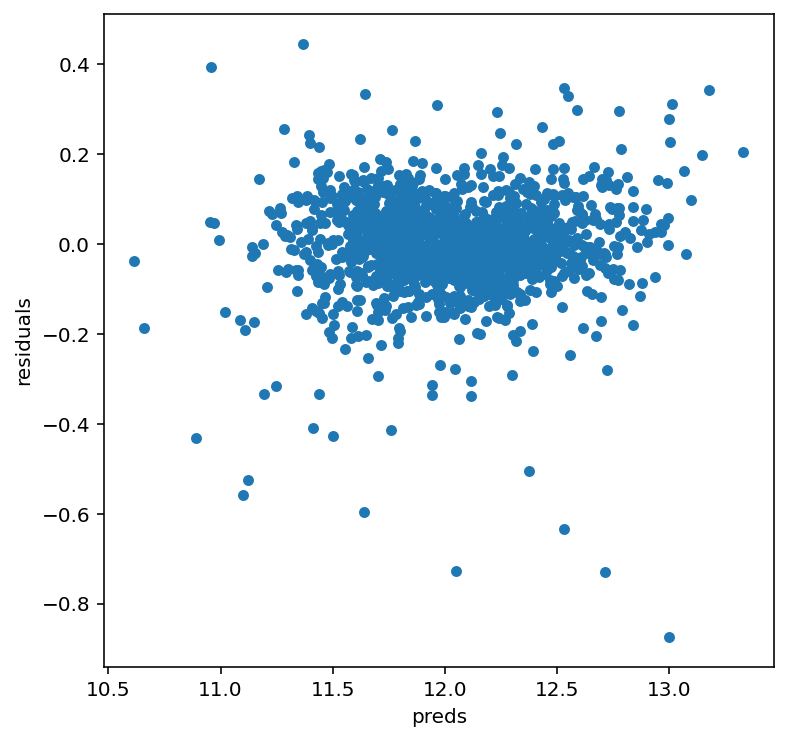

In [22]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

***Adding an xgboost model***

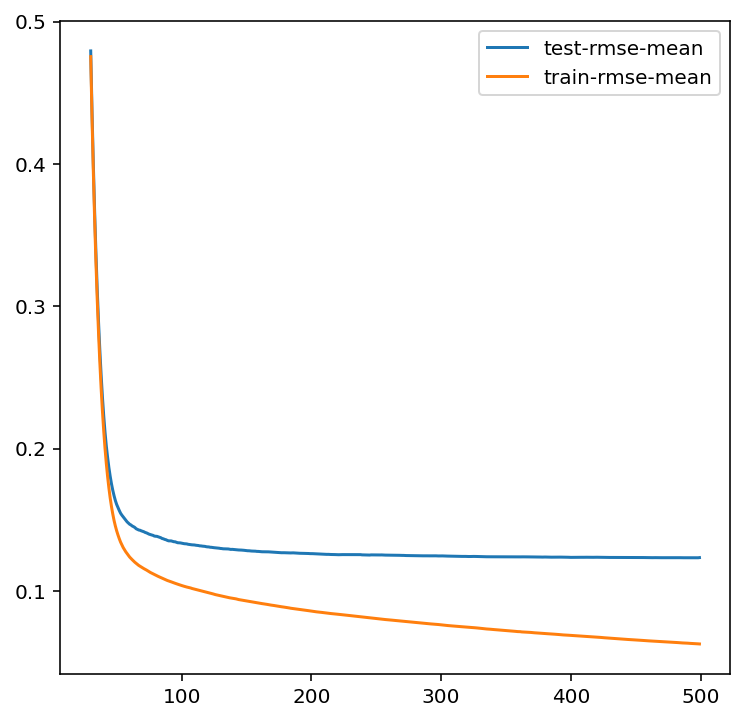

In [23]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [24]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

[06:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [25]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

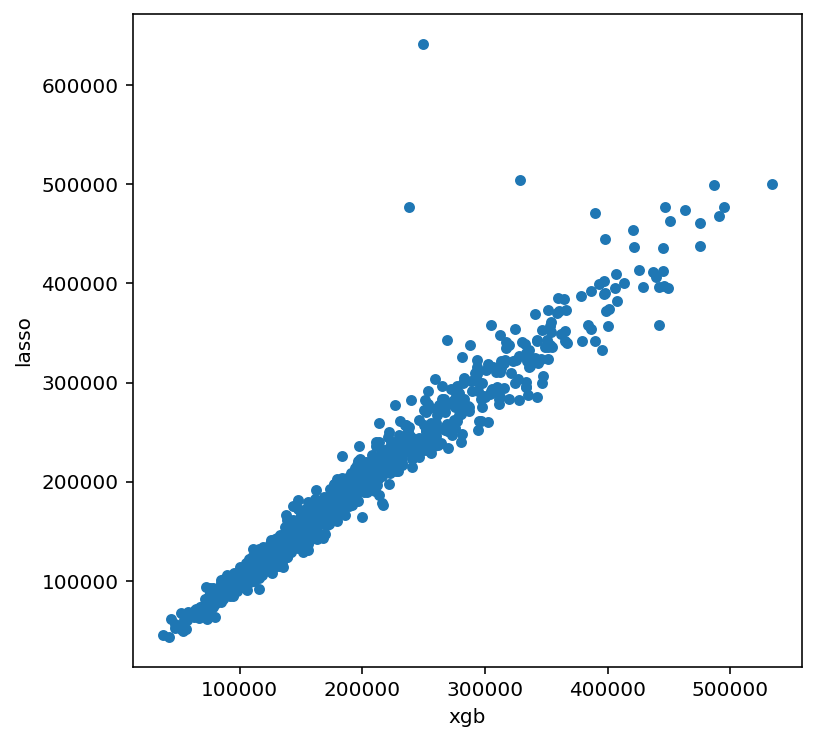

In [26]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [27]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

print("Hasil Prediksi : ", preds)

Hasil Prediksi :  [120129.31638285 153008.78931275 181999.67177217 ... 165128.54225094
 119034.14941217 227808.93476155]


In [28]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("Hasil_predic.csv", index = False)

solution.head()

,id,SalePrice
0,1461,120129.316383
1,1462,153008.789313
2,1463,181999.671772
3,1464,195952.284998
4,1465,197477.812587


***Trying out keras?***

Feedforward Neural Nets tampaknya tidak bekerja dengan baik sama sekali...

In [29]:
X_train = StandardScaler().fit_transform(X_train)

Menentukan parameter random_state bertujuan untuk dapat 
memastikan bahwa hasil pembagian dataset konsisten dan memberikan 
data yang sama setiap kali model dijalankan. 

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 10)

In [31]:
X_tr.shape

(1095, 288)

In [32]:
X_tr

array([[-1.12520184,  0.18320317,  0.22511533, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 2.08318944, -0.30038284,  0.43545438, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.42446233,  0.39999105,  0.14338742, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.42446233,  0.04567596,  0.96953077, ..., -0.11785113,
        -2.13834494,  3.26802693],
       [ 0.64507285, -0.87075036, -0.01136012, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.42446233,  0.83059739,  0.38799203, ..., -0.11785113,
        -2.13834494,  3.26802693]])

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [34]:
model = Sequential()

model.add(Dense(1, input_dim=X_train.shape[1], kernel_regularizer=l1(0.001)))
#model.add(Dense(512, activation='relu', W_regularizer=l2(0.0001)))
# Compile model
model.compile(loss="mse", optimizer="adam")

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [36]:
hist = model.fit(
    X_tr, y_tr,
    steps_per_epoch = 25,
    epochs = 15, 
    validation_data = (X_val, y_val),
    validation_steps = 5
)

Epoch 1/15
25/25 [==============================] - 3s 10ms/step - loss: 147.1393 - val_loss: 147.1554
Epoch 2/15
25/25 [==============================] - 0s 4ms/step - loss: 145.5447 - val_loss: 147.4290
Epoch 3/15
25/25 [==============================] - 0s 4ms/step - loss: 144.3275 - val_loss: 147.8103
Epoch 4/15
25/25 [==============================] - 0s 4ms/step - loss: 143.2585 - val_loss: 148.3067
Epoch 5/15
25/25 [==============================] - 0s 4ms/step - loss: 142.3326 - val_loss: 148.9716
Epoch 6/15
25/25 [==============================] - 0s 4ms/step - loss: 141.2593 - val_loss: 149.4090
Epoch 7/15
25/25 [==============================] - 0s 5ms/step - loss: 140.3454 - val_loss: 150.1453
Epoch 8/15
25/25 [==============================] - 0s 5ms/step - loss: 139.4282 - val_loss: 150.7540
Epoch 9/15
25/25 [==============================] - 0s 4ms/step - loss: 138.5091 - val_loss: 151.3930
Epoch 10/15
25/25 [==============================] - 0s 4ms/step - loss: 137.6329

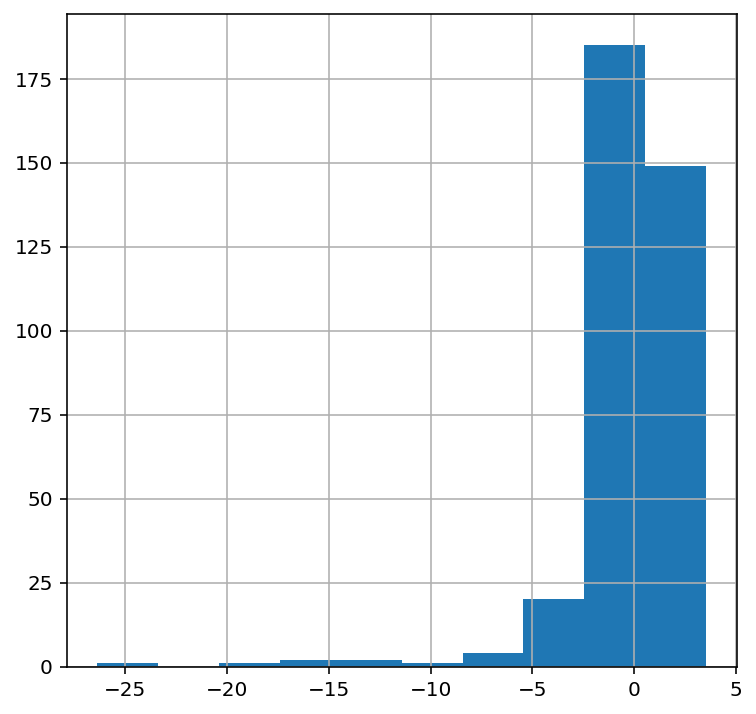

In [37]:
pd.Series(model.predict(X_val)[:,0]).hist()